In [1]:
!pip install qiskit
!pip install qiskit-ibm-runtime
!pip install qiskit-aer
!pip install 'qiskit[visualization]'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import qiskit_ibm_runtime
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector, Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
# Get a fake backend from the fake provider
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

In [3]:
# method 1: Using diagonalization

H = np.matrix([[-20.3052, -0.84040, -1.21530],[-0.84040, -18.6023, -0.58900],[-1.21530, -0.58900, -15.6467]])
e,v = np.linalg.eig(H)

print('EigenValues : ', e)
print('EigenVectors: ', v)
print()
print('Ground State Energy:', min(e))

EigenValues :  [-20.99027321 -18.25947269 -15.30445409]
EigenVectors:  [[-0.89413618 -0.39241849 -0.21570401]
 [-0.37502775  0.91945388 -0.11814715]
 [-0.24469302  0.02474465  0.9692848 ]]

Ground State Energy: -20.990273214759483


In [4]:
# method 2: Using classical variational method having 1 parameter c

H = np.matrix([[-20.3052, -0.84040, -1.21530],[-0.84040, -18.6023, -0.58900],[-1.21530, -0.58900, -15.6467]])

def classical_variational_1parameter(hamiltonian):
  def energy(c):
    s = np.sqrt(1-c**2)
    psi_c = np.matrix([[float(c), float(s), 0.0],[-float(s), float(c), 0.0], [ 0.0, 0.0, 1.0]])   # parameterized wavefunction matrix
    ec = psi_c.T @ hamiltonian @ psi_c     # expectation value
    return np.real(ec[0,0])
  result = minimize(energy, 0.5, bounds = [(-1, 1)])
  min_energy = result.fun
  optimal_c = result.x[0]
  return min_energy , optimal_c

min_energy, optimal_c = classical_variational_1parameter(H)
print(f" ground state energy (minimum eigenvalue): {min_energy}")
print()
print(f"Optimal c: {optimal_c}")
print()

 ground state energy (minimum eigenvalue): -20.3052

Optimal c: 1.0



/var/folders/hc/8pcw73b94qq896mhyxzmh7m00000gn/T/ipykernel_4571/1778993440.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  psi_c = np.matrix([[float(c), float(s), 0.0],[-float(s), float(c), 0.0], [ 0.0, 0.0, 1.0]])   # parameterized wavefunction matrix


In [5]:
# method 3: Using classical variational method having two parameters c1 and c2

H = np.matrix([[-20.3052, -0.84040, -1.21530],[-0.84040, -18.6023, -0.58900],[-1.21530, -0.58900, -15.6467]])


def classical_variational_2parameters(H):
    def energy(params):
        c1, c2 = params
        s1 = np.sqrt(1 - c1**2)
        s2 = np.sqrt(1 - c2**2)
        psi_c = np.array([
            [c1, -s1*c2, -s1*s2],
            [s1*c2, c1*c2, -c1*s2],
            [s1*s2, c1*s2, c2]
        ])
        return np.real((psi_c.T @ H @ psi_c)[0, 0])

    result = minimize(energy, [0.5, 0.5], bounds=[(-1, 1), (-1, 1)])
    min_energy = result.fun
    optimal_c1, optimal_c2 = result.x

    return min_energy, optimal_c1, optimal_c2

min_energy, optimal_c1, optimal_c2 = classical_variational_2parameters(H)
print(f"Minimum eigenvalue: {min_energy}")
print()
print(f"Optimal c1: {optimal_c1}")
print(f"Optimal c2: {optimal_c2}")

Minimum eigenvalue: -20.990273214759306

Optimal c1: 0.894136078568027
Optimal c2: 0.8374986456506429


In [6]:
# Estimator using Fake Provider
backend = FakeManilaV2()
estimator = Estimator(mode=backend)
#Giving number of shots
estimator.options.default_shots = 10000

In [7]:
# Hamiltonian for JW
hamiltonian = SparsePauliOp.from_list([("III", -27.2771),("IIZ", 10.1526),("IZI", 9.30115),("ZII", 7.82335),("IXX", -0.4202),("IYY", -0.4202),("XZX", -0.60765),("YZY", -0.60765),("XXI", -0.2945),("YYI", -0.2945)])



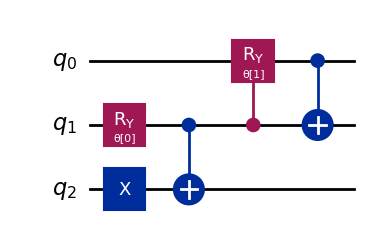

In [8]:
#Ansatze for JW
theta = ParameterVector('θ', 2)
ansatz = QuantumCircuit(3)
ansatz.ry(theta[0],1)
ansatz.x(2)
ansatz.cx(1,2)
ansatz.cry(theta[1], 1, 0)
ansatz.cx(0,1)
ansatz.draw("mpl")

In [9]:
# Transpile the Hamiltonian and ansatz
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
ansatz_isa = pm.run(ansatz)
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

In [10]:
backend = FakeManilaV2()
estimator = Estimator(mode=backend)
#Giving number of shots
estimator.options.default_shots = 10000

In [11]:
#Function to calcuate energy
def variational(params, ansatz, hamiltonian, estimator):
  pub = (ansatz, hamiltonian, [params])
  result = estimator.run(pubs=[pub]).result()
  energy = result[0].data.evs[0]
  return energy

In [12]:
# Minimization function for each Hamiltonian
def minimization(ansatz_isa, hamiltonian_isa, ansatz):
    x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)
    result = minimize(
        variational,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="COBYLA"
    )
    return result.fun

In [17]:
# ground state energy from VQE

result = minimization(ansatz_isa, hamiltonian_isa, ansatz)
print(f"Ground state energy of JW: {result}")


Ground state energy of JW: -20.032198700000002


In [14]:
runs = np.arange(1,11,1)
E_runs = []
for i in runs:
    E_runs.append(minimization(ansatz_isa, hamiltonian_isa, ansatz))
print(f"JW: {E_runs}")

JW: [-20.23591719, -20.158407999999998, -19.906167169999996, -19.967944270000004, -20.069521420000008, -20.130874400000007, -20.22266125, -19.933811939999995, -20.05680142, -20.04848747]


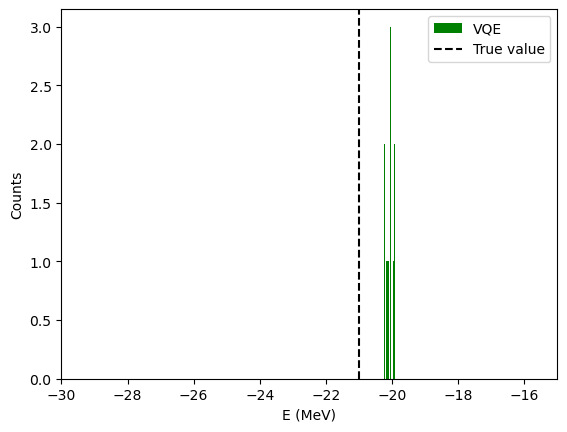

In [15]:
# True value for 58Ni
true_value = -20.99027321 # (MeV)

plt.hist(np.array(E_runs),label = 'VQE',color = 'green')
plt.xlabel('E (MeV)')
plt.ylabel('Counts')
plt.axvline(x = true_value, ymin = 0, ymax = 1, linestyle = '--', c = 'k', label = 'True value')
plt.xlim(-30,-15)
plt.legend()
plt.show()